# matchms tutorial
## part III - create a network based on spectral similarities
This is part of a matchms and Spec2Vec tutorial.  
Part I --> https://blog.esciencecenter.nl/build-your-own-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-i-d96c718c68ee

Part II --> https://blog.esciencecenter.nl/build-a-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-ii-spec2vec-8aa639571018

Part III -->

Here we will start with data that was processed in the part I and II.
See notebook part I: https://github.com/matchms/matchms/blob/tutorial/tutorial/matchms_tutorial_01_building_analysis_pipeline.ipynb

See notebook part II: https://github.com/matchms/matchms/blob/tutorial/tutorial/matchms_tutorial_02_compute_similarities_with_Spec2Vec.ipynb


### Requirements
For this notebook to work, you must have `matchms`, `Spec2Vec`, and `matchmsextras` installed.
This can be done by running:

```
conda create --name spec2vec python=3.8
conda activate spec2vec
conda install --channel nlesc --channel bioconda --channel conda-forge spec2vec>=0.40
pip install matchmsextras
```
Here we used `spec2vec 0.5.0`, `matchms 0.9.1`, and `matchmsextras 0.2.3`.

## Import data
- We will here use data that was imported and processed in the notebook on part I.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matchms.importing import load_from_json

path_data = os.path.join(os.path.dirname(os.getcwd()), "data") #"..." enter your pathname to the downloaded file
file_json = os.path.join(path_data, "GNPS-NIH-NATURALPRODUCTSLIBRARY_processed.json")
spectrums = list(load_from_json(file_json))

In [2]:
print(f"{len(spectrums)} spectrums found and imported")

1267 spectrums found and imported


---

# Spec2Vec
As described in part II, we will here load a pretrained model and apply it to compute all spectrum-spectrum similarities.

## 1. Load a pretrained Spec2Vec model
For many use-cases we would not advice to retrain a new model from scratch. Instead a more general model that has been trained on a large MS/MS dataset can simply be loaded and used to calculate similarities, even for spectra which were not part of the initial model training.

Here we can download a model trained on about 95,000 spectra from GNPS (positive ionmode) which we provide here: https://zenodo.org/record/4173596.

Let's now load this model:

In [3]:
import gensim

path_model = os.path.join(os.path.dirname(os.getcwd()), "data", "trained_models") #"..." enter your pathname to the downloaded file
filename_model = "spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model"
filename = os.path.join(path_model, filename_model)

model = gensim.models.Word2Vec.load(filename)

C:\Users\FlorianHuber\Anaconda3\envs\matchms-dev\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


It is very important to make sure that the "documents" are created the same way as for the model training. This mostly comes down here to the number of decimals which needs to be the same here than for the pretrained model. To inspect the words the model has learned, we can look at `model.wv` which is the "vocabulary" the model has learned.

In [10]:
model.wv.index_to_key[0]  # shows the first word in vocabulary

'peak@105.07'

This means the model will expect words with 2 decimals!

In [11]:
print(f"Learned vocabulary contains {len(model.wv)} words.")

Learned vocabulary contains 115910 words.


## Compute similarities

In [12]:
from matchms import calculate_scores
from spec2vec import Spec2Vec

spec2vec_similarity = Spec2Vec(model=model,
                               intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

scores = calculate_scores(spectrums, spectrums, spec2vec_similarity,
                          is_symmetric=True)

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.


The warning that 1 word is missing means that one peak in the data does not occur in the model vocabulary. Since it seems to be a small peak, the impact of this is small (0.19%) and will be ignored.

## Compute network/graph from similarities

Graphs based on similarities can be generated (and pruned/modified) in many different ways. Here we will start rather simple. The function `create_network()` will create a node for each spectrum. Then it will add edges (connections) for each node in the following way: For each spectrum, the `max_links` highest scoring connections will be added, as long as they have a similarity score of `> cutoff`. That means, per node, between 0 (if no high enough similarity exist) and `max_links` connections will be added.

In [15]:
import networkx as nx
import matchmsextras.networking as net

our_network = net.create_network(scores,
                                 cutoff=0.7,
                                 max_links=10)

Actually, that's it. Now a network was generated. 

There is now multiple possible next steps to inspect the results.

## 1. We can plot the network with Python (or better: with networkx)

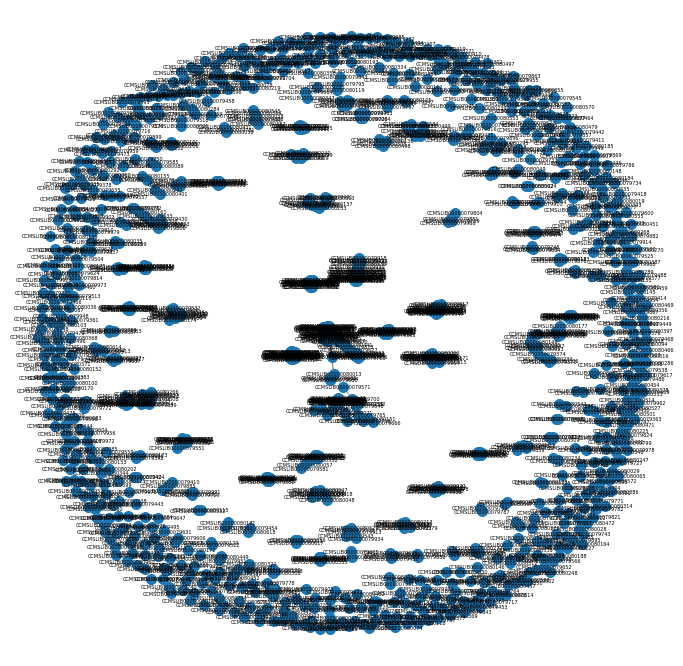

In [32]:
net.plot_cluster(our_network)

Lacking any interactivity this kind of plot is not very helpful.

So we could move on to

## 2. Plot individual clusters

In [33]:
subnetworks = [our_network.subgraph(c).copy() for c in nx.connected_components(our_network)]

In [54]:
list(subnet.nodes)[0]

'CCMSLIB00000080355'

In [57]:
clusters = {}
for i, subnet in enumerate(subnetworks):
    if len(subnet.nodes) > 2: # exclude clusters with <=2 nodes
        clusters[i] = len(subnet.nodes)

clusters

{6: 7,
 8: 4,
 12: 5,
 14: 10,
 15: 3,
 16: 4,
 17: 18,
 19: 32,
 20: 10,
 23: 59,
 25: 6,
 28: 4,
 37: 4,
 38: 11,
 46: 4,
 51: 4,
 52: 4,
 57: 7,
 60: 10,
 61: 8,
 64: 11,
 69: 8,
 74: 17,
 76: 10,
 79: 20,
 82: 3,
 84: 10,
 86: 11,
 88: 28,
 90: 18,
 97: 8,
 98: 10,
 121: 11,
 124: 4,
 130: 8,
 136: 5,
 140: 4,
 144: 3,
 146: 7,
 151: 3,
 152: 7,
 162: 8,
 166: 7,
 168: 3,
 170: 10,
 172: 3,
 174: 4,
 180: 3,
 188: 3,
 192: 4,
 195: 4,
 196: 3,
 203: 3,
 207: 7,
 210: 15,
 226: 6,
 232: 3,
 238: 3,
 246: 3,
 280: 4,
 291: 3,
 294: 10,
 297: 3,
 302: 4,
 319: 4,
 320: 3,
 322: 3,
 345: 4,
 347: 3,
 372: 4,
 451: 5}

Now, let's plot one of those clusters separately.

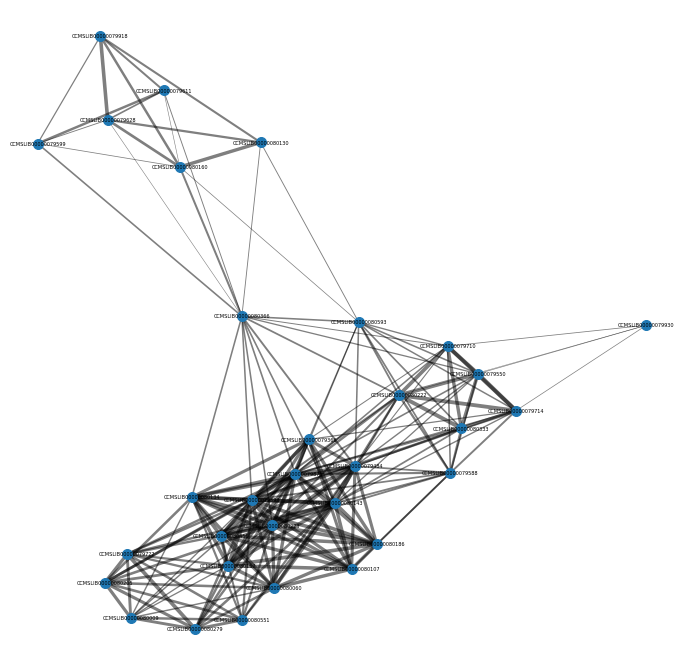

In [58]:
net.plot_cluster(subnetworks[19])

That is more insightful. Yet, to interactively explore the graph it is generally better to go to

## 3. Export the graph and plot elsewhere (e.g. Cytoscape)

This comprises two steps. First, we will export the graph/network as a `graphml` file which contains all edges and nodes.
Second, we will also export the metadata which can later be used to color or label the graph.

In [59]:
# export the graph
nx.write_graphml(our_network, "network_GNPS_cutoff_07.graphml")

In [61]:
# collect the metadata
metadata = net.extract_networking_metadata(spectrums)
metadata.head()

,smiles,compound_name,parent_mass
CCMSLIB00000079350,OC(=O)[C@H](NC(=O)CCN1C(=O)[C@@H]2Cc3ccccc3CN2...,"(2R)-2-[3-[(10aS)-1,3-dioxo-10,10a-dihydro-5H-...",None
CCMSLIB00000079351,O=C(N1[C@@H](C#N)C2OC2c3ccccc13)c4ccccc4,"(2S)-3-benzoyl-2,7b-dihydro-1aH-oxireno[2,3-c]...",None
CCMSLIB00000079352,COc1cc(O)c2c(=O)cc(oc2c1)c3ccccc3,5-hydroxy-7-methoxy-2-phenylchromen-4-one,None
CCMSLIB00000079353,COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1/C=C\4/C(=...,"N-[2-[7-methoxy-6-[(Z)-(2,4,6-trioxo-1-prop-2-...",None
CCMSLIB00000079354,CC(C)[C@H](NC(=O)N1[C@@H](C(C)C)C(=O)Nc2ccccc1...,(2S)-2-[[(2S)-3-methyl-2-[[(2S)-3-oxo-2-propan...,None


In [62]:
# export the metadata
metadata.to_csv("network_GNPS_metadata.csv")